## FP Propagation 

*In the following notebook a guide for evaluating the approximated FP  propagation to 10 and 1 cm is described.*

### 1. Libraries and parameters

#### Libraries initialization

In [14]:
import numpy as np
import torch
from torch import nn
from torch import fft
import scipy.io
from scipy import interpolate
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Parameters initialization

In [22]:
ds=0.005 #sampling rate at every 5mm
fs=1/ds #sampling frequency
L=20 #number of sample points 
l=L-1 #L-position
D=0.295 #physical distance range
c=3e8 #field propagation velocity
f=3e9 #sampling freqeuncy
lambd=c/f #wavelength
k=2*np.pi/lambd #wave vector

#### Correlation function

In [29]:
mat=scipy.io.loadmat('Hy_R1(x1,y1,x2,y2)_36pos_1cm.mat') #Hy_R1(x1,y1,x2,y2)_36pos_1cm.mat upload. This .mat script is a Matlab workspace including the Hy_R1 4-D complex matrix. In python this workspace is converted into a dictonary. 
Hy_R1=torch.tensor(mat['Hy_R1'],dtype=torch.cfloat) #Hy_R1 matrix is taken from the dictonary and converted into tensor. Hy_R1 is 60x60x60x60 complex tensor.
CF_full=torch.permute(Hy_R1,(0,2,1,3)) #correlation function (CF) is built by permuting the Hy_R1 tensor
del Hy_R1 #Hy_R1 deletion for saving space

#### Correlation function lite

In [30]:
CF=torch.zeros(20,20,20,20, dtype=torch.cfloat)
w=0
for lunghezza in range(0,60,3):
    k=0
    for cubo in range(0,60,3):
        i=0
        for riga in range(0,60,3):
            j=0
            for colonna in range(0,60,3):
                CF[w,k,i,j]=CF_full[lunghezza,cubo,riga,colonna]
                j=j+1
            i=i+1
        k=k+1
    w=w+1

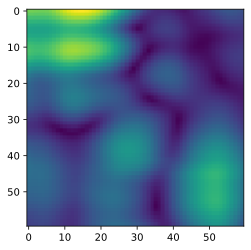

In [37]:
plt.imshow(torch.abs(CF_full[:,0,0,:]))
plt.show()

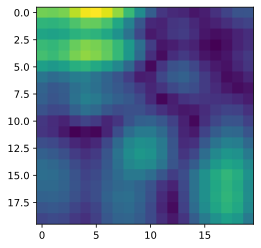

In [38]:
plt.imshow(torch.abs(CF[:,0,0,:]))
plt.show()

### 2. Variable change - Part 1

In [39]:
Q=torch.zeros(2*L-1,2*L-1, dtype=torch.cfloat) #preallocate Q
AA=torch.zeros(2*L-1,2*L-1,L,L, dtype=torch.cfloat) #preallocate AA

for k in range(0,L):
    for n in range(0,L): 
        R=CF[:,:,k,n] #R(x1,x2)
        
        #Variable rotation for each inner matrix R(X2,X1) -> R(x,sx)
        for X1 in range(1,L+1): #nx matrix
            for X2 in range(1,L+1): #ny matrix
                x=(X1+X2)/2 #change of variable X1, X2 to x
                sx=round(X1-X2) #change of variable X1, X2 to sx
                Q[sx+L-1,(X1+X2)-2]=R[X1-1,X2-1] #Q(sx,x) matrix
        #Averaging in between the values already calculated after variable change
        for h in range(1,2*L-2,2):
            Q[h,l]=(Q[h-1,l]+Q[h,l-1]+Q[h,l+1]+Q[h+1,l])/4 #Q[h,l]
        for t in range(1,L):
            for m in range(1,L):
                Q[m+t-1,L-m+t-1]=(Q[m+t-2,L-m+t-1]+Q[m+t-1,L-m+t-2]+Q[m+t-1,L-m+t]+Q[m+t,L-m+t-1])/4
        
        #After averaging, arrangement of the rotated inner matrix into AA(sx,x,x2,y2)
        AA[:,:,k,n]=Q #AA(sx,x,y2,y1) matrix
        
del CF, R, Q #CF, R, Q deletion

### 3. Variable change - Part 2

In [40]:
R=AA #AA matrix duplicate, AA(sx,x,y1,y2)
q=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #preallocate q

#Variable change on the outer correlation matrix R(X1,X2) -> R(x,s)
for y1 in range(1,L+1): #nx matrix
    for y2 in range(1,L+1): #ny matrix
        y=(y1+y2)/2 #change of variable y1, y2 to y
        sy=(y1-y2) #change of variable y1, y2 to sy 
        q[:,:,sy+L-1,(y1+y2)-2]=R[:,:,y1-1,y2-1] #D(s,x) matrix

#Averaging in between the real value after variable change
for h in range(1,2*L-2,2):
    q[:,:,h,l] = (q[:,:,h-1,l]+q[:,:,h,l-1]+q[:,:,h,l+1]+q[:,:,h+1,l])/4
for t in range(1,L):
    for m in range(1,L):
        q[:,:,m+t-1,L-m+t-1] = (q[:,:,m+t-2,L-m+t-1]+q[:,:,m+t-1,L-m+t-2]+q[:,:,m+t-1,L-m+t]+q[:,:,m+t,L-m+t-1])/4

del R, AA #R, AA deletion

### 4. Rearrangement of $Q(sx,x,sy,y)$ into $Q(sy,sx,y,x)$ and FFT2 execution on sx and sy 

In [41]:
CFr=torch.permute(q,(2,0,3,1)) #rearrange Q to be CFr(sy,sx,y,x)
del q #q deletion

pmax=lambd/2*fs #pmax
rang = 1.5 #new P range: -1.5 < P < 1.5 
NFFT=round((2*L-1)*(lambd*fs)/(rang*2)) #zero padding value
WF=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #Wigner Function (WF) initialization

for y in range(0,2*L-1):
    print(y, end =" ")
    for x in range(0,2*L-1):
        s=CFr[:,:,y,x]
        padx=(NFFT-(2*L-1))/2 #padding value
        S=torch.tensor(np.pad(s,round(padx)))
        #For range -1.5 to 1.5 with zero padding
        S1=fft.fftshift(fft.fft2((fft.ifftshift(S))))
        WF[:,:,y,x]= S1[math.ceil(-L+(NFFT/2)+1)-1:math.ceil(L+(NFFT/2)-1),math.ceil(-L+(NFFT/2)+1)-1:math.ceil(L+(NFFT/2)-1)] #WF(py,px,y,x)
print('Done!')

del CFr, s, S, S1 #CFr, s, S, S1 deletion

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 Done!


### 5. Plot $\text{WF}(py,px,y,x)$

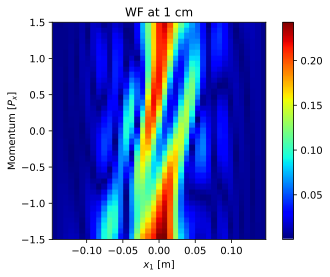

In [52]:
plt.figure()
plt.imshow(torch.squeeze(torch.abs((WF[l,:,l,:]))), cmap='jet', extent=[-D/2,D/2,-1.5,1.5], aspect = 0.10)
plt.title('WF at 1 cm')
plt.xlabel("$x_1$ [m]")
plt.ylabel("Momentum [$P_x$]")
plt.colorbar()
plt.show()

### 6. Frobenius Perron Approximation - Wigner Transformed Function (x-domain)

In [53]:
pmax=lambd/2*fs #pmax
NFFT=2*L-1 #zero padding value
z=0.09 #propagaion distance
n=2*L-1 #resolution
x1, y1 = torch.meshgrid(torch.linspace(-D/2,D/2,n),torch.linspace(-D/2,D/2,n), indexing='xy')
Px=torch.linspace(-1.5,1.5,NFFT)
Py=torch.linspace(-1.5,1.5,NFFT)
mag_p=torch.zeros(NFFT,NFFT)

for ipy in range(0,NFFT):
    for ipx in range(0,NFFT):
        mag_p[ipy,ipx]=torch.sqrt(Px[ipx]**2+Py[ipy]**2) #Mag_p(py,px)

### 7. FP on $\text{WF}(py,px,y,x)$

In [44]:
Wq1 = torch.zeros(2*L-1,n) #preallocate Wq1
WF2=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #preallocate WF2

for py in range(0, NFFT): #py
    print(py, end =" ")
    for px in range(0,NFFT): #px
        Wx = torch.squeeze(WF[py,px,:,:]) #Wx(y,x) from WF3/WF(py,px,y,x)
        
        #Transform domain
        #Interpolate W with new xq and yq axes
        if torch.abs(mag_p[py,px]) < 1 : #FP propagation
            xq = x1 - z*(Px[px]/torch.sqrt(1-torch.abs(mag_p[py,px])**2))
            yq = y1 - z*(Py[py]/torch.sqrt(1-torch.abs(mag_p[py,px])**2))
            Wq1 = interpolate.griddata((yq.ravel(), xq.ravel()), Wx.ravel(), (y1.ravel(), x1.ravel()), method='cubic', fill_value=0) #1-D data interpolation
            Wq1 = torch.tensor(Wq1).view(2*L-1,2*L-1)
        
        else: #Evanescent propagation
            F = interpolate.griddata((y1.ravel(), x1.ravel()), Wx.ravel(), (y1.ravel(), x1.ravel()), method='cubic', fill_value=0) #1-D data interpolation
            F = torch.tensor(F).view(2*L-1,2*L-1)
            Wq1 = torch.exp(-2*k*z*torch.sqrt(mag_p[py,px]**2-1))* F
        WF2[py,px,:,:] = Wq1 #WF3(py,px,yq,xq)
print('Done!')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 Done!


### 8. Plot $WF3(py,px,yq,xq)$

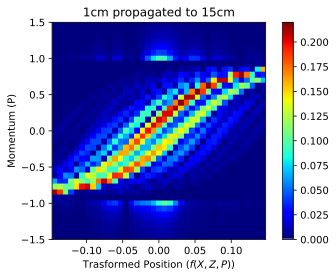

In [58]:
wf2=torch.squeeze(WF2[l,:,l,:])
plt.figure()
plt.imshow(np.squeeze(np.abs((wf2))),cmap='jet', extent=[-D/2,D/2,-1.5,1.5], aspect = 0.10)
plt.title('1cm propagated to 15cm')
plt.xlabel("Trasformed Position ($f(X, Z, P)$)")
plt.ylabel("Momentum (P)")
plt.colorbar()
plt.show()

### 8. Inverse WF 

In [46]:
CFr2=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #preallocate CFr2

for y in range(0,2*L-1):
    for x in range(0,2*L-1):
        g=fft.fftshift(fft.ifft2(fft.ifftshift(torch.squeeze(WF2[:,:,y,x]))))
        CFr2[:,:,y,x]=g #CFr2(sy,sx,y,x)
        
CFr3= torch.permute(CFr2,(1,3,0,2)) #CFr3(sx,x,sy,y)

### 9. Plot WF

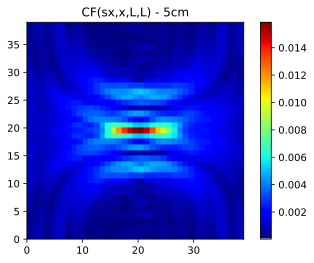

In [59]:
cfr3=torch.squeeze(CFr3[:,:,l,l])
plt.figure()
plt.imshow(torch.abs(torch.squeeze(cfr3)),cmap='jet', extent=[0,2*L-1,0,2*L-1])
plt.title('CF(sx,x,L,L) - 5cm')
plt.colorbar()
plt.show()

### 10. Change of variable $\text{CFr2}(:,:,sy,y)$ into $\text{CFr2}(:,:,y1,y2)$

In [60]:
Cr=torch.zeros(2*L-1,2*L-1,L,L, dtype=torch.cfloat) #preallocate Cr

for y1 in range(1,L+1): #nx matrix 
    for y2 in range(1,L+1): #ny matrix
        y = (y1+y2)/2 #change of variable y1, y2 to y
        sy = (y1-y2) #change of variable y1, y2 to sy
        Cr[:,:,y1-1,y2-1]=CFr3[:,:,sy+L-1,(y1+y2)-2] 

### 11. Change of variable $\text{F}(sx,x)$ into $\text{F}(x1,x2)$

In [61]:
RR=torch.zeros(L,L, dtype=torch.cfloat) #preallocate RR
CF2=torch.zeros(L,L,L,L, dtype=torch.cfloat) #preallocate CF2

for k in range (0, L):
    for n in range(0, L):
        F = Cr[:,:,k,n]
        for X1 in range(1, L+1):
            for X2 in range(1, L+1):
                x = (X1+X2)/2 #change of variable X1, X2 to x
                sx = (X1-X2) #change of variable X1, X2 to sx
                RR[X1-1,X2-1] = F[sx+L-1,(X1+X2)-2] #RR(X1,X2)
        CF2[:,:,k,n] = RR #set CF2(x1,x2,y1,y2)

### 12. Hy_CF3 evaluation

In [62]:
mat2 = scipy.io.loadmat('SF1.mat')
SF1=torch.tensor(mat2['SF1'],dtype=torch.cfloat)
Hy_CF3=CF2*SF1

### 13. Plot HY_CF3

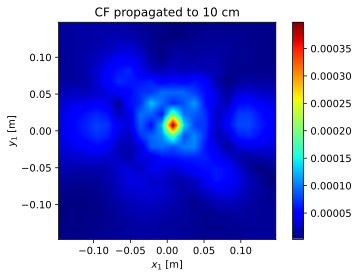

In [63]:
hy_cf3=torch.fliplr(torch.squeeze(Hy_CF3[round(l/2),:,round(l/2),:]))
plt.figure()
plt.imshow(torch.abs(hy_cf3).T,cmap='jet', interpolation="bilinear",extent=[-D/2,D/2,-D/2,D/2])
plt.title('CF propagated to 10 cm')
plt.xlabel("$x_1$ [m]")
plt.ylabel("$y_1$ [m]")
plt.colorbar()
plt.show()